In [72]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn as sk
import contextlib
import statsmodels.api as sm
import scipy.signal


% pylab inline

#for python2, uncomment the below line:
#from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [73]:
#http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
#set a function to manage the print options of specific arrays
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

**Import Data, Check Healthiness, Verify Can Drop NAs**

(this is a preliminary run through, using only NY County, All Industry Sectors, quarterly data from 2000 - 2014)

In [74]:
#reading in QWI indicators for the 4 counties in NYC (New York, Kings)

df = pd.read_csv('~/Documents/GRA/QWI_indicators/qwi_5c2543d712bc416f82683ab99e1517f6.csv')

In [75]:
#print out a list of columns
#df.columns

In [76]:
#remove the flags, which have a lowercase s followed by a capitalized column name
columns_no_flags = [word for word in df.columns if not word[1].isupper()]

#subset to new DF with no flags
df = df[columns_no_flags]
df.columns = [x.replace('.','_') for x in df.columns]

In [77]:
def print_full(x):
    #this function takes in a dataframe and prints the head of the df with all columns displayed
    #it then resets back to the default column display afterwards
    pd.set_option('display.max_columns', 500)
    print(x.head(10))
    pd.reset_option('display.max_columns')
    
#print_full(df)
#df.dtypes

In [78]:
#create new column 'period' that maps the year and quarter
df['period'] = df.year.map(str) + "_" + df.quarter.map(str)


In [79]:
#want data for Manhattan (county = 'New York, NY')
df_ny = df[df.geography_label_value == 'New York, NY']
#only using data from all industries in this example
mask = (df_ny.industry == '00')
df_ny_all = df_ny[mask]
#set the period as the index, so we can keep it when we go to all numerics
df_ny_all = df_ny_all.set_index(df_ny_all.period)


In [80]:
#select numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df_ny_all.select_dtypes(include=numerics)

#move period back from index
data.reset_index(level=0, inplace=True)



In [81]:
#drop geography, sex, firmage, firmsize
data.drop(['geography', 'sex', 'firmage', 'firmsize'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


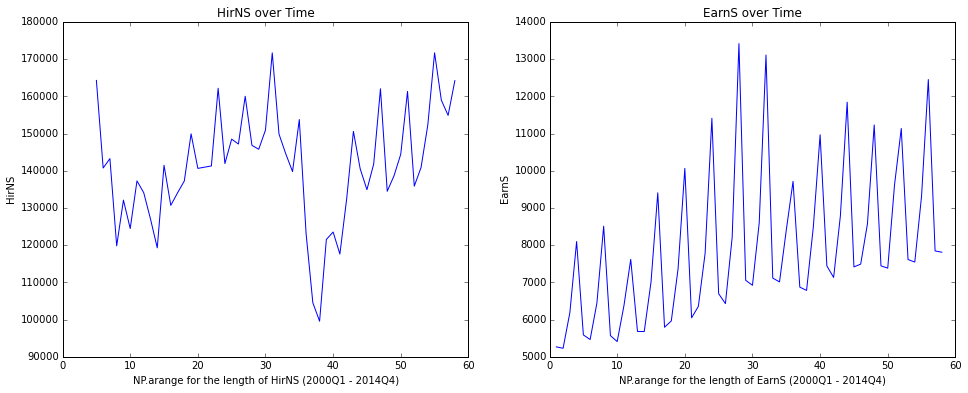

In [82]:
#before drop the NANs, verify position
#from printout, can see there are 6 in HirNS, 2 in EarnS

#check number of NaNs before Drop the values
#print(data.isnull().sum())

#points_ax1 = np.arange(len(data.HirNS))

fig, ((ax1, ax2)) = plt.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'all data')
ax1.set_xlabel('NP.arange for the length of HirNS (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirNS')
ax1.set_title('HirNS over Time')

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'all data')
ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS over Time')


#based off the graph below, these are in early 2000 and then again in late 2014. Can now drop them
data = data.dropna()
data = data.reset_index()

In [83]:
#cacluate percent change in new hires and add to dataframe
HirN_per = [0]
for i in np.arange(len(data['HirN'])-1):
#    while i < max(np.arange(len(data['HirN']))):
    #for i in len[data.HirN]:
    change = (data.ix[i+1,'HirN'] - data.ix[i,'HirN'])/data.ix[i,'HirN']
    HirN_per.append(change)
#print (HirN_per)

data['HirN_per'] = HirN_per

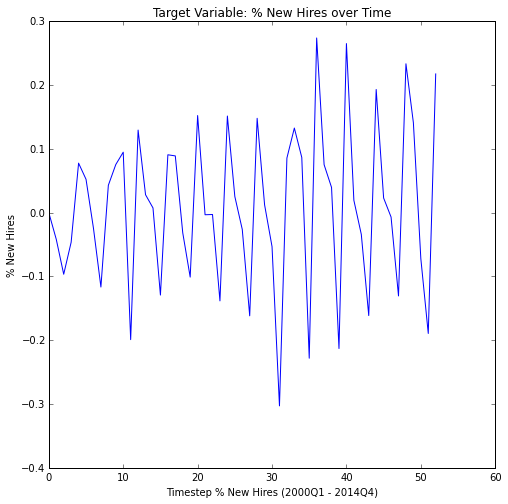

In [95]:
figure, ax1 = pl.subplots(figsize=(8,8))
ax1.plot(np.arange(len(data.HirN_per)), data.HirN_per, label = 'all data')
ax1.set_xlabel('Timestep % New Hires (2000Q1 - 2014Q4)')
ax1.set_ylabel('% New Hires')
ax1.set_title('Target Variable: % New Hires over Time')


In [84]:
data.head()
data.drop(['index'], axis=1, inplace=True)

**Principle Component Analysis, v1**

(using all columns -- doing with sklearn)

In [85]:
#convert dataframe to a numpy array
X= data.as_matrix()
print(X.shape)

#drop the first three columns: period, year, quarter -- all that remains are the numeric indicator columns
y = X[:,-1]
X = X[:,3:-1]
#print(X.shape)
#print(y.shape)

from sklearn.preprocessing import normalize
from sklearn import decomposition

#normalize the data
X_norm = sk.preprocessing.normalize(X, norm='l2', axis=0, copy=True)

principles = 3

#pca = decomposition.PCA(n_components = 'mle')
pca = decomposition.PCA(n_components = principles)
pca.fit(X_norm)
X_norm_t = pca.transform(X_norm)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 


(53, 36)
PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.631  0.18   0.086]


In [86]:
#get the weights of each of the features by vector space
i = np.identity(X_norm.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=data.columns[3:-1])


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)

PCA PARAMETERS:
 {'copy': True, 'n_components': 3, 'whiten': False} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
Emp           0.064 -0.015 -0.183
EmpEnd        0.054 -0.026 -0.184
EmpS          0.056 -0.015 -0.200
EmpSpv        0.065 -0.023 -0.204
EmpTotal      0.065 -0.026 -0.151
HirA          0.069 -0.087  0.022
HirN          0.071 -0.073 -0.020
HirR          0.063 -0.134  0.156
Sep           0.122 -0.028  0.034
HirAEnd       0.046 -0.108 -0.062
HirAEndR      0.050 -0.111 -0.049
SepBeg        0.130 -0.013 -0.048
SepBegR       0.136 -0.016 -0.035
HirAS         0.031  0.034 -0.024
HirNS         0.035  0.009 -0.084
SepS          0.134 -0.049 -0.060
SepSnx        0.080  0.009 -0.112
TurnOvrS      0.063  0.012 -0.038
FrmJbGn       0.012 -0.162 -0.065
FrmJbLs       0.203  0.046 -0.026
FrmJbC       -0.567 -0.741 -0.254
HirAEndRepl   0.076 -0.060 -0.061
HirAEndReplR  0.081 -0.064 -0.047
FrmJbGnS      0.007  0.073  0.051
FrmJbLsS      0.211 -0.088 -0.028
FrmJbCS      -0.642  0.545  0.1

In [87]:
print('PCA WEIGHTS, PC-1 >0.1: \n', weights[weights['PC-1'].abs() > 0.1])

PCA WEIGHTS, PC-1 >0.1: 
            PC-1   PC-2   PC-3
Sep       0.122 -0.028  0.034
SepBeg    0.130 -0.013 -0.048
SepBegR   0.136 -0.016 -0.035
SepS      0.134 -0.049 -0.060
FrmJbLs   0.203  0.046 -0.026
FrmJbC   -0.567 -0.741 -0.254
FrmJbLsS  0.211 -0.088 -0.028
FrmJbCS  -0.642  0.545  0.152


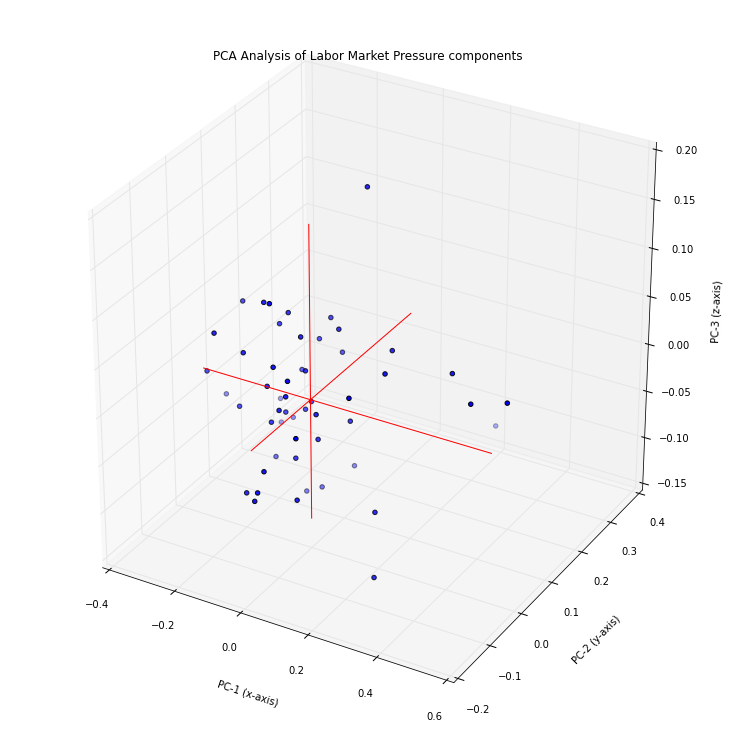

In [88]:
#Graph PCA and do a regression off of it
from mpl_toolkits.mplot3d import Axes3D

fig1 = pl.figure(figsize = (10,10)) # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.
pltData = [X_norm_t[:, 0], X_norm_t[:, 1], X_norm_t[:, 2]] 
ax.scatter(pltData[0], pltData[1], pltData[2], 'bo') # make a scatter plot of blue dots from the data
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.

yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.

zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("PC-1 (x-axis)") 
ax.set_ylabel("PC-2 (y-axis)")
ax.set_zlabel("PC-3 (z-axis)")
ax.set_title("PCA Analysis of Labor Market Pressure components")

In [89]:
regress = pd.DataFrame(X_norm_t, columns=['PC_1', 'PC_2', 'PC_3'])
regress['y'] = y
regress['y'] = regress['y'].convert_objects(convert_numeric=True)

In [90]:
X1 = regress[['PC_1', 'PC_2', 'PC_3']]
y1 = regress['y']

In [91]:
X1 = sm.add_constant(X1)
est = sm.OLS(y1, X1).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     19.03
Date:                Fri, 13 Nov 2015   Prob (F-statistic):           2.55e-08
Time:                        17:34:49   Log-Likelihood:                 53.645
No. Observations:                  53   AIC:                            -99.29
Df Residuals:                      49   BIC:                            -91.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0086      0.013      0.686      0.496        -0.017     0.034
PC_1           0.1611      0.074      2.173      0.035         0.012     0.310
PC_2          -0.9726      0.139     -6.998      0.000        -1.252    -0.693
PC_3           0.3712      0.201      1.846      0.071        -0.033     0.775
==============================================================================
Omnibus:                        1.436   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                0.869
Skew:                          -0.301   Prob(JB):                        0.648
Kurtosis:                       3.177   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
#ANOTHER OPTION: A regression with the "heavier" variables in the dataset

print('PCA WEIGHTS: \n', weights[weights['PC-1'].abs() > 0.1])

#subset the raw data to get a new regression off of these 5 original variables

cols = weights[weights['PC-1'].abs() > 0.1].index.tolist()
X2 = data[cols].as_matrix()
#print(X2.shape)

#normalize the data and run regression
X2_norm = sk.preprocessing.normalize(X2, norm='l2', axis=0, copy=True)


regress2 = pd.DataFrame(X2_norm, columns=cols)
regress2['y'] = y
regress2['y'] = regress2['y'].convert_objects(convert_numeric=True)

X2 = regress2[cols]
y2 = regress2['y']


X2 = sm.add_constant(X2)
est2 = sm.OLS(y2, X2).fit()

est2.summary()


PCA WEIGHTS: 
            PC-1   PC-2   PC-3
Sep       0.122 -0.028  0.034
SepBeg    0.130 -0.013 -0.048
SepBegR   0.136 -0.016 -0.035
SepS      0.134 -0.049 -0.060
FrmJbLs   0.203  0.046 -0.026
FrmJbC   -0.567 -0.741 -0.254
FrmJbLsS  0.211 -0.088 -0.028
FrmJbCS  -0.642  0.545  0.152


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     29.94
Date:                Fri, 13 Nov 2015   Prob (F-statistic):           2.24e-15
Time:                        17:34:49   Log-Likelihood:                 82.545
No. Observations:                  53   AIC:                            -147.1
Df Residuals:                      44   BIC:                            -129.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0549      0.124      0.444      0.659        -0.194     0.304
Sep            4.8121      0.891      5.399      0.000         3.016     6.608
SepBeg         8.4086      3.427      2.454      0.018         1.502    15.315
SepBegR       -5.2225      2.601     -2.008      0.051       -10.465     0.020
SepS          -8.9740      2.950     -3.042      0.004       -14.919    -3.029
FrmJbLs       -7.9677      0.783    -10.181      0.000        -9.545    -6.390
FrmJbC        -0.0131      0.125     -0.104      0.917        -0.266     0.240
FrmJbLsS       8.6909      1.465      5.934      0.000         5.739    11.642
FrmJbCS       -0.1989      0.111     -1.791      0.080        -0.423     0.025
==============================================================================
Omnibus:                        0.731   Durbin-Watson:                   2.755
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.532
Skew:                           0.244   Prob(JB):                        0.766
Kurtosis:                       2.942   Cond. No.                         699.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
#ANOTHER OPTION: with job creation / destruction heavy variables


#subset the raw data to get a new regression off of these 5 original variables

cols = ['EarnHirNS','EarnHirAS', 'EmpS', 'FrmJbGn', 'FrmJbLs', 'FrmJbGnS', 'FrmJbLsS']
X3 = data[cols].as_matrix()
#print(X2.shape)

#normalize the data and run regression
X3_norm = sk.preprocessing.normalize(X3, norm='l2', axis=0, copy=True)


regress3 = pd.DataFrame(X3_norm, columns=cols)
regress3['y'] = y
regress3['y'] = regress2['y'].convert_objects(convert_numeric=True)

X3 = regress3[cols]
y3 = regress3['y']


X3 = sm.add_constant(X3)
est3 = sm.OLS(y3, X3).fit()

est3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     13.17
Date:                Fri, 13 Nov 2015   Prob (F-statistic):           4.36e-09
Time:                        17:34:50   Log-Likelihood:                 62.709
No. Observations:                  53   AIC:                            -109.4
Df Residuals:                      45   BIC:                            -93.66
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0328      0.333     -0.099      0.922        -0.703     0.638
EarnHirNS     -0.6863      1.701     -0.404      0.688        -4.112     2.739
EarnHirAS      1.2984      2.033      0.639      0.526        -2.796     5.393
EmpS           0.3965      2.289      0.173      0.863        -4.213     5.006
FrmJbGn       -0.0884      0.600     -0.147      0.884        -1.298     1.121
FrmJbLs       -5.9111      0.769     -7.684      0.000        -7.461    -4.362
FrmJbGnS      -0.9938      0.587     -1.694      0.097        -2.175     0.188
FrmJbLsS       6.2884      0.764      8.234      0.000         4.750     7.827
==============================================================================
Omnibus:                        1.558   Durbin-Watson:                   2.514
Prob(Omnibus):                  0.459   Jarque-Bera (JB):                1.356
Skew:                          -0.385   Prob(JB):                        0.508
Kurtosis:                       2.853   Cond. No.                         253.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""